<a href="https://colab.research.google.com/github/Munna-Prasad-Gupta/ML/blob/main/bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 87ms/step - accuracy: 0.6918 - loss: 3.0714 - val_accuracy: 0.6981 - val_loss: 2.3474 - learning_rate: 1.0000e-04
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.7000 - loss: 2.3244 - val_accuracy: 0.6978 - val_loss: 2.3332 - learning_rate: 1.0000e-04
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.7024 - loss: 2.2758 - val_accuracy: 0.6987 - val_loss: 2.2907 - learning_rate: 1.0000e-04
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.7021 - loss: 2.2443 - val_accuracy: 0.6981 - val_loss: 2.2864 - learning_rate: 1.0000e-04
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.7019 - loss: 2.2233 - val_accuracy: 0.6990 - val_loss: 2.2664 - learning_rate: 1.0000e-04
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 0.7028 - loss: 2.1949 - val_accuracy: 0.6992 - val_loss: 2.2404 - learning_rate: 1.0000e-04
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━

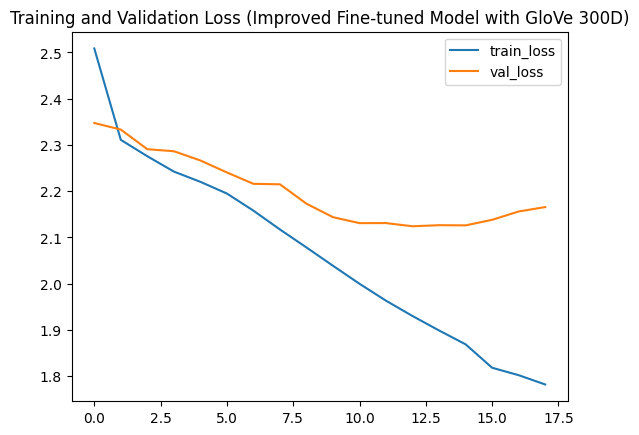

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
Translation: आप आप देखें


In [4]:
import numpy as np
import pandas as pd
import string
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
from datasets import load_dataset
df = load_dataset("Aarif1430/english-to-hindi")
da = pd.DataFrame(df['train'])

# Data Preprocessing
da.rename(columns={'english_sentence': 'english', 'hindi_sentence': 'hindi'}, inplace=True)
da['english'] = da['english'].str.replace('[{}]'.format(string.punctuation), '', regex=True).str.lower()
da['hindi'] = da['hindi'].str.replace('[{}]'.format(string.punctuation), '', regex=True).str.lower()

# Remove empty rows
eng_empty_indices = da[da['english'].str.strip().astype(bool) == False].index
hin_empty_indices = da[da['hindi'].str.strip().astype(bool) == False].index
remove_indices = list(set(eng_empty_indices) | set(hin_empty_indices))
da.drop(remove_indices, inplace=True)
da.reset_index(drop=True, inplace=True)

# Tokenization with vocabulary limit
tokenizer_eng = Tokenizer(num_words=20000)  # Limit English vocabulary
tokenizer_eng.fit_on_texts(da['english'])
sequences_eng = tokenizer_eng.texts_to_sequences(da['english'])

tokenizer_hin = Tokenizer(num_words=20000)  # Limit Hindi vocabulary
tokenizer_hin.fit_on_texts(da['hindi'])
sequences_hin = tokenizer_hin.texts_to_sequences(da['hindi'])

# Pad sequences with reduced max length
max_length = 50
sequences_eng = pad_sequences(sequences_eng, maxlen=max_length, padding='post')
sequences_hin = pad_sequences(sequences_hin, maxlen=max_length, padding='post')

# Vocabulary sizes
vocab_size_eng = min(30000, len(tokenizer_eng.word_index) + 1)
vocab_size_hin = min(30000, len(tokenizer_hin.word_index) + 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(sequences_eng[:100000], sequences_hin[:100000], test_size=0.2, random_state=42)

# Load pre-trained GloVe 300D embeddings
embedding_dim = 300  # GloVe 300D
glove_path = 'glove.6B.300d.txt'  # Path to the GloVe 300D file

# Prepare GloVe embeddings
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare the embedding matrix for the tokenizer (with GloVe 300D)
embedding_matrix = np.zeros((vocab_size_eng, embedding_dim))
for word, i in tokenizer_eng.word_index.items():
    if i < vocab_size_eng:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build Bidirectional LSTM model with improved GloVe 300D embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size_eng, output_dim=embedding_dim, input_length=max_length,
                    weights=[embedding_matrix], trainable=True))  # Allow GloVe embeddings to be fine-tuned
model.add(Bidirectional(LSTM(units=1024, return_sequences=True)))  # Increase LSTM units
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))
model.add(Dropout(0.4))
model.add(LSTM(units=512))  # Decoding LSTM
model.add(RepeatVector(max_length))  # Repeat vector for decoder
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))  # Another bidirectional LSTM layer
model.add(Dropout(0.4))
model.add(Dense(units=512, activation='relu'))  # Additional dense layer
model.add(Dense(units=vocab_size_hin, activation='softmax'))  # Output layer

# Compile with Adam optimizer and learning rate decay
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Updated callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

# Save model and training history
model.save('bilstm_finetuned_glove_300d_improved_model.h5')
with open('bilstm_finetuned_glove_300d_improved_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save tokenizers
with open('tokenizer_eng.pkl', 'wb') as f:
    pickle.dump(tokenizer_eng, f)
with open('tokenizer_hin.pkl', 'wb') as f:
    pickle.dump(tokenizer_hin, f)

# Plot loss and accuracy
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation Loss (Improved Fine-tuned Model with GloVe 300D)')
plt.show()

# Functions for translation
def preprocess_sentence(sentence, tokenizer, max_length):
    sentence = sentence.lower().strip()
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

def decode_sequence(sequence, tokenizer):
    reverse_word_index = {idx: word for word, idx in tokenizer.word_index.items()}
    decoded_sentence = ' '.join([reverse_word_index.get(idx, '') for idx in sequence if idx > 0])
    return decoded_sentence

def translate_sentence(sentence):
    # Preprocess the input English sentence
    input_seq = preprocess_sentence(sentence, tokenizer_eng, max_length)

    # Predict the output sequence
    predicted_seq = model.predict(input_seq)
    predicted_seq = np.argmax(predicted_seq, axis=-1)

    # Decode the predicted sequence into Hindi
    translated_sentence = decode_sequence(predicted_seq[0], tokenizer_hin)
    return translated_sentence

# Example usage
sentence = "Hello, how are you?"
translation = translate_sentence(sentence)
print("Translation:", translation)


Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.6873 - loss: 3.2582 - val_accuracy: 0.7007 - val_loss: 2.3301 - learning_rate: 1.0000e-04
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.7006 - loss: 2.3255 - val_accuracy: 0.7008 - val_loss: 2.3114 - learning_rate: 1.0000e-04
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.7002 - loss: 2.3076 - val_accuracy: 0.7012 - val_loss: 2.2968 - learning_rate: 1.0000e-04
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.7015 - loss: 2.2718 - val_accuracy: 0.7009 - val_loss: 2.2920 - learning_rate: 1.0000e-04
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.7011 - loss: 2.2431 - val_accuracy: 0.7001 - val_loss: 2.2863 - learning_rate: 1.0000e-04
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.7012 - loss: 2.2257 - val_accuracy: 0.7017 - val_loss: 2.2461 - learning_rate: 1.0000e-04
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━

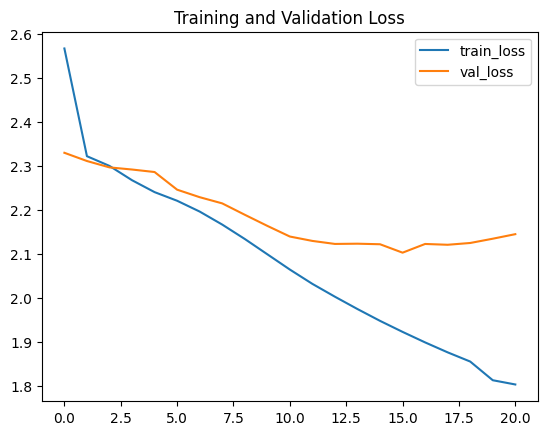

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Translation: आप आप


In [6]:
import numpy as np
import pandas as pd
import string
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
from datasets import load_dataset
df = load_dataset("Aarif1430/english-to-hindi")
da = pd.DataFrame(df['train'])

# Data Preprocessing
da.rename(columns={'english_sentence': 'english', 'hindi_sentence': 'hindi'}, inplace=True)
da['english'] = da['english'].str.replace('[{}]'.format(string.punctuation), '', regex=True).str.lower()
da['hindi'] = da['hindi'].str.replace('[{}]'.format(string.punctuation), '', regex=True).str.lower()

# Remove empty rows
da.dropna(subset=['english', 'hindi'], inplace=True)
da.reset_index(drop=True, inplace=True)

# Tokenization with vocabulary limit
tokenizer_eng = Tokenizer(num_words=20000)
tokenizer_eng.fit_on_texts(da['english'])
sequences_eng = tokenizer_eng.texts_to_sequences(da['english'])

tokenizer_hin = Tokenizer(num_words=20000)
tokenizer_hin.fit_on_texts(da['hindi'])
sequences_hin = tokenizer_hin.texts_to_sequences(da['hindi'])

# Pad sequences
max_length = 50
sequences_eng = pad_sequences(sequences_eng, maxlen=max_length, padding='post')
sequences_hin = pad_sequences(sequences_hin, maxlen=max_length, padding='post')

# Vocabulary sizes
vocab_size_eng = min(20000, len(tokenizer_eng.word_index) + 1)
vocab_size_hin = min(20000, len(tokenizer_hin.word_index) + 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(sequences_eng[:100000], sequences_hin[:100000], test_size=0.2, random_state=42)

# Load GloVe 300D embeddings
embedding_dim = 300
glove_path = 'glove.6B.300d.txt'
embeddings_index = {}

# Prepare GloVe embeddings
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Embedding matrix
embedding_matrix = np.zeros((vocab_size_eng, embedding_dim))
for word, i in tokenizer_eng.word_index.items():
    if i < vocab_size_eng:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model
model = Sequential([
    Embedding(input_dim=vocab_size_eng, output_dim=embedding_dim, input_length=max_length,
              weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(units=512, return_sequences=True)),
    Dropout(0.4),
    BatchNormalization(),
    LSTM(units=256, return_sequences=True),
    Dropout(0.4),
    LSTM(units=256),
    RepeatVector(max_length),
    Bidirectional(LSTM(units=256, return_sequences=True)),
    Dropout(0.4),
    Dense(units=512, activation='relu'),
    Dense(units=vocab_size_hin, activation='softmax')
])

# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

# Save model and training history
model.save('bilstm1_finetuned_glove_300d_improved_model.h5')
with open('bilstm1_finetuned_glove_300d_improved_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save tokenizers
with open('tokenizer_eng1.pkl', 'wb') as f:
    pickle.dump(tokenizer_eng, f)
with open('tokenizer_hin1.pkl', 'wb') as f:
    pickle.dump(tokenizer_hin, f)

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Translation functions
def preprocess_sentence(sentence, tokenizer, max_length):
    sentence = sentence.lower().strip()
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

def decode_sequence(sequence, tokenizer):
    reverse_word_index = {idx: word for word, idx in tokenizer.word_index.items()}
    decoded_sentence = ' '.join([reverse_word_index.get(idx, '') for idx in sequence if idx > 0])
    return decoded_sentence

def translate_sentence(sentence, model, max_length, tokenizer_eng, tokenizer_hin):
    input_seq = preprocess_sentence(sentence, tokenizer_eng, max_length)
    predicted_seq = model.predict(input_seq)
    predicted_seq = np.argmax(predicted_seq, axis=-1)
    translated_sentence = decode_sequence(predicted_seq[0], tokenizer_hin)
    return translated_sentence

# Example usage
sentence = "Hello, how are you?"
translation = translate_sentence(sentence, model, max_length, tokenizer_eng, tokenizer_hin)
print("Translation:", translation)
